In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

sns.set_theme()

In [ ]:
#For inflation
import cpi
#cpi.update() #NOTE: Run this on first time you import to get most updated info from CPI

In [2]:
df = pd.read_csv("../Data Collection/monthly_without_hpi.csv")
df.head()

,Fips,Year,Population,Interest Rate,Month,Unemployment Rate,HPA
0,1,2010,4785514.0,0.5,1,9.8,881
1,2,2010,713982.0,0.5,1,9.8,24
2,4,2010,6407342.0,0.5,1,9.8,1258
3,5,2010,2921998.0,0.5,1,9.8,411
4,6,2010,37319550.0,0.5,1,9.8,3022


In [3]:
#Add datetime column
df['datetime'] = df['Year'].astype(str) +"-"+ df['Month'].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,Fips,Year,Population,Interest Rate,Month,Unemployment Rate,HPA,datetime
0,1,2010,4785514.0,0.5,1,9.8,881,2010-01-01
1,2,2010,713982.0,0.5,1,9.8,24,2010-01-01
2,4,2010,6407342.0,0.5,1,9.8,1258,2010-01-01
3,5,2010,2921998.0,0.5,1,9.8,411,2010-01-01
4,6,2010,37319550.0,0.5,1,9.8,3022,2010-01-01


# Visualize a few HPA trend on singular fips

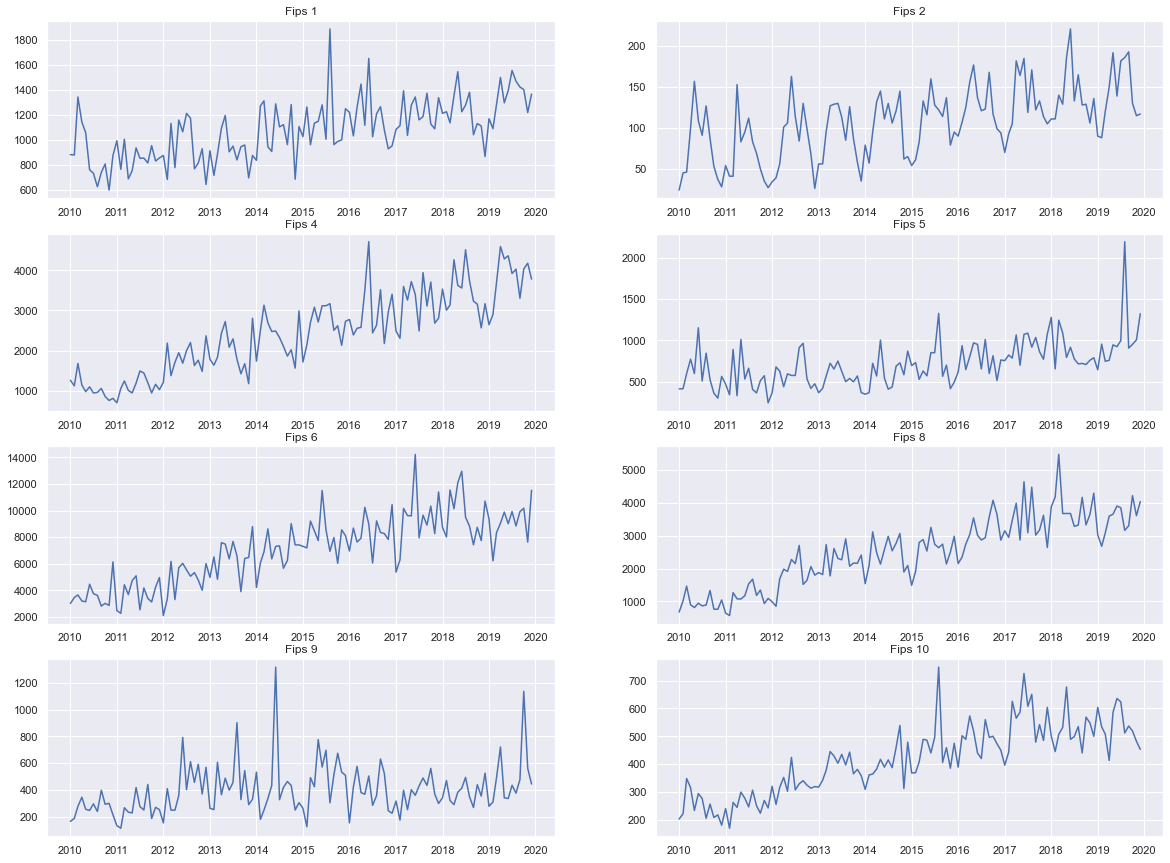

In [4]:
n = 8 #Change this for FIPS regions to show
nrow = 4 #Change subplots row to match 'n'
ncol = 2 #Change subplots col to match 'n'

fig,axes = plt.subplots(nrow,ncol,figsize=(20,15))
fips_rng = np.unique(df['Fips'])[:n]
for i, ax in enumerate(axes.reshape(-1)):
    fips_df = df[df['Fips']==fips_rng[i]] #filter df to just that fips number
    ax.plot(fips_df['datetime'], fips_df['HPA'])
    ax.set_title('Fips '+str(fips_rng[i]))

# There is likely a seasonality attribute here. Let's try adjusting:
#### Fips region 1: Apply seasonal decomposition (additive model)

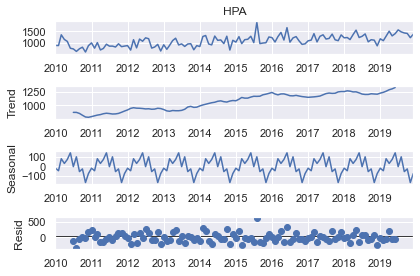

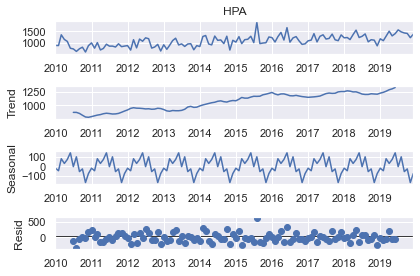

In [5]:
fips_df = df[df['Fips']==1].copy()
fips_df.set_index(fips_df['datetime'], inplace=True)
res = sm.tsa.seasonal_decompose(fips_df['HPA'])
res.plot()

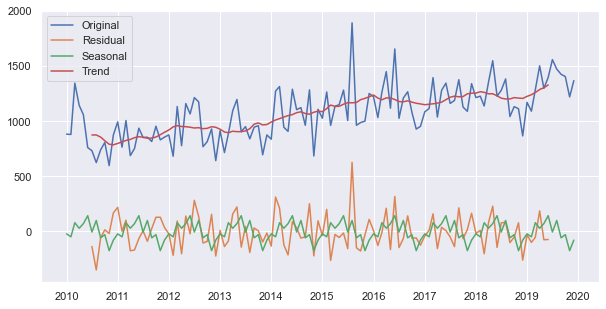

In [6]:
# Add results to original df
fips_df['observed'] = res.observed
fips_df['residual'] = res.resid
fips_df['seasonal'] = res.seasonal
fips_df['trend'] = res.trend

# Plotting all together 
plt.figure(figsize=(10,5))
plt.plot(fips_df['datetime'], fips_df['HPA'], label='Original')
plt.plot(fips_df['datetime'], fips_df['residual'], label='Residual')
plt.plot(fips_df['datetime'], fips_df['seasonal'], label='Seasonal')
plt.plot(fips_df['datetime'], fips_df['trend'], label='Trend')
plt.legend()
plt.show()

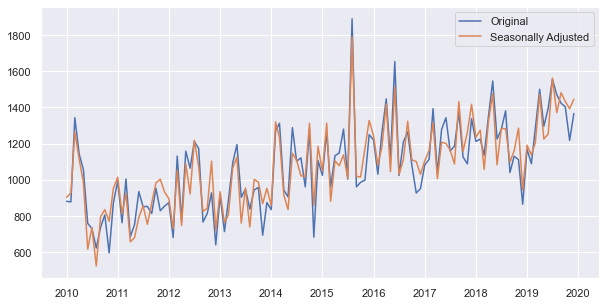

In [7]:
#Show seasonally adjusted data
plt.figure(figsize=(10,5))
plt.plot(fips_df['datetime'], fips_df['HPA'], label='Original')
plt.plot(fips_df['datetime'], fips_df['HPA']-fips_df['seasonal'], label='Seasonally Adjusted')
plt.legend()
plt.show()

### We can also adjust seasonality with STL:

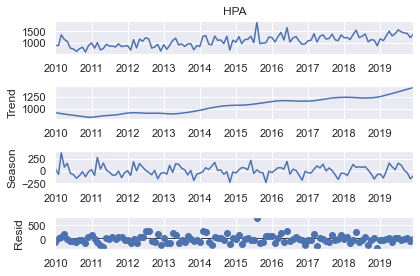

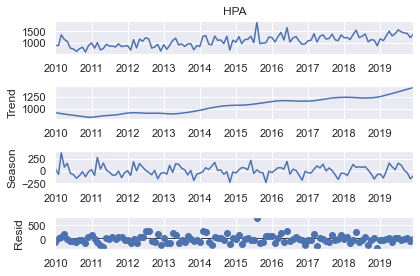

In [8]:
stl_model = sm.tsa.STL(fips_df['HPA'], robust=True)
stl_res = stl_model.fit()
stl_res.plot()

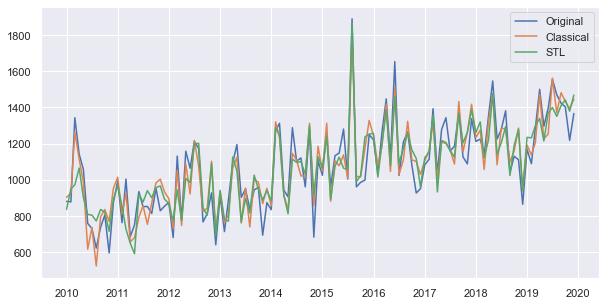

In [9]:
fips_df['stl_seasonal'] = stl_res.seasonal

#Show seasonally adjusted data
plt.figure(figsize=(10,5))
plt.plot(fips_df['datetime'], fips_df['HPA'], label='Original')
plt.plot(fips_df['datetime'], fips_df['HPA']-fips_df['seasonal'], label='Classical')
plt.plot(fips_df['datetime'], fips_df['HPA']-fips_df['stl_seasonal'], label='STL')
plt.legend()
plt.show()

### In this case, seasonality is a small factor based on model parameters and trend has higher significance.

# Visualize this with several Fips at once (Classical decomposition for now)

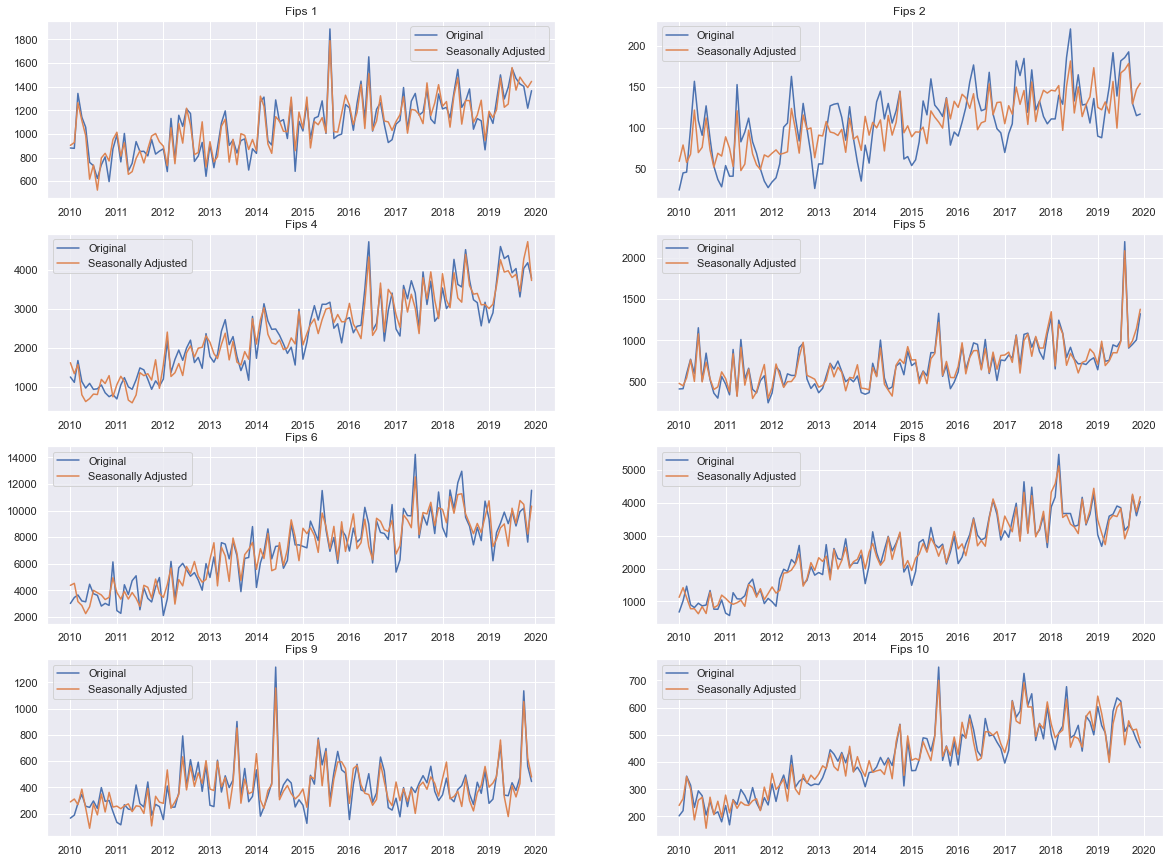

In [10]:
n = 8 #Change this for FIPS regions to show
nrow = 4 #Change subplots row to match 'n'
ncol = 2 #Change subplots col to match 'n'

fig,axes = plt.subplots(nrow,ncol,figsize=(20,15))
fips_rng = np.unique(df['Fips'])[:n]
for i, ax in enumerate(axes.reshape(-1)):
    fips_df = df[df['Fips']==fips_rng[i]].copy() #filter df to just that fips number
    fips_df.set_index(fips_df['datetime'], inplace=True)
    res = sm.tsa.seasonal_decompose(fips_df['HPA'])
    fips_df['seasonal'] = res.seasonal  
    ax.plot(fips_df['datetime'], fips_df['HPA'], label='Original')
    ax.plot(fips_df['datetime'], fips_df['HPA']-fips_df['seasonal'], label='Seasonally Adjusted')
    ax.legend()
    ax.set_title('Fips '+str(fips_rng[i]))

# Inflation Adjustment (only works on USD)
# TODO: Revisit this with DTI or some other column with only USD?
### Plot year vs. medianIncome as test

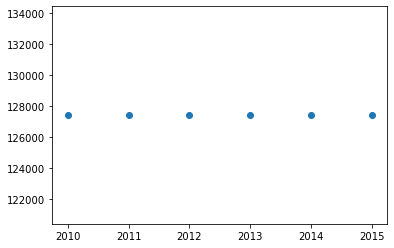

In [10]:
test_df = fips_df[fips_df['RegionID'] == 394311]
plt.scatter(test_df['Year'], test_df['medianIncome'])

### Plot after inflation adjustment.

C:\Users\j88796\AppData\Local\Continuum\anaconda3\envs\complex_sar\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


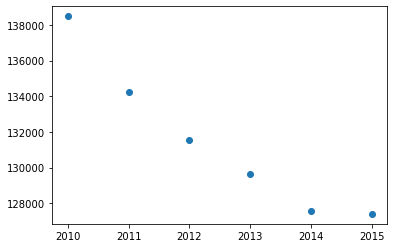

In [13]:
test_df["real_dollars"] = test_df.apply(lambda x: cpi.inflate(x["medianIncome"], x["Year"], to=2015), axis=1)
plt.scatter(test_df['Year'], test_df['real_dollars'])